# Staggered Difference-in-Differences Tutorial

## Using CausalAnalyzer and CausalDashboard Directly

This notebook demonstrates how to use the **core components** of the library directly:
- `CausalPropensityScore` - Propensity score estimation
- `PropensityMatcher` - Matching treated and control units
- `CausalAnalyzer` - Staggered DiD estimation (Callaway & Sant'Anna style)
- `CausalDashboard` - Visualization and reporting

### What You'll Learn
1. **Data Preparation** - Setting up panel data for causal analysis
2. **Propensity Score Matching** - Reducing confounding
3. **Staggered DiD Estimation** - ATT(g,t), Overall ATT, Event Study
4. **Diagnostics** - Pre-trend tests, balance checks
5. **Visualization** - Dashboard methods for reporting

---


In [1]:
# Setup and Imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core library components (used directly, not through CausalPipeline)
from src.propensity_model import CausalPropensityScore
from src.matching import PropensityMatcher
from src.causal_analyzer import CausalAnalyzer
from src.causal_dashboard import CausalDashboard

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Setup complete - using core components directly")


✓ Setup complete - using core components directly


## 1. Architecture Overview

This library separates concerns into distinct components:

```
┌─────────────────────┐     ┌──────────────────┐     ┌─────────────────┐
│ CausalPropensityScore│ ──▶ │ PropensityMatcher │ ──▶ │ CausalAnalyzer  │
│ (Score estimation)   │     │ (Pair matching)   │     │ (DiD estimation)│
└─────────────────────┘     └──────────────────┘     └────────┬────────┘
                                                              │
                                                              ▼
                                                     ┌─────────────────┐
                                                     │ CausalDashboard │
                                                     │ (Visualization)  │
                                                     └─────────────────┘
```

**Key Benefit**: Using these components directly gives you full control over each step.

---


## 2. Generate Sample Data with Known True Effects

We'll create realistic panel data where we **know the true treatment effect**, so we can validate the estimator recovers it correctly.


In [2]:
from sample_data import generate_sample_data

# True treatment effect we want to recover
TRUE_EFFECT = 15000

# Generate data
data = generate_sample_data(
    n_accounts=5000,              # Total units
    n_treatment_accounts=1000,     # ~10% treated
    treatment_effect=TRUE_EFFECT, # Known true effect
    noise_scale=10000,             # Realistic noise
    selection_mode='realistic',    # Balanced selection into treatment
    effect_pattern='growing',    # Constant effect over time
    random_state=42
)

df_panel = data['feature_store']
df_treatment = data['treatment_table']

print(f"Panel data shape: {df_panel.shape}")
print(f"Treatment records: {len(df_treatment)}")
print(f"True treatment effect: {TRUE_EFFECT:,}")


Panel data shape: (120000, 15)
Treatment records: 1000
True treatment effect: 15,000


In [3]:
# Examine the data
print("Panel data sample:")
display(df_panel.head())

print("\nTreatment data sample:")
display(df_treatment.head())


Panel data sample:


,cod_conta,num_ano_mes,val_cap_liq,auc,val_receita,vl_rentabilidade_liquida_mes,vl_rentabilidade_liquida_12m,tx_enquadramento,segmento,cod_tipo_pessoa,dsc_marca_conta,n_acessos_hub,potencial,ultima_nota_nps_ass,ativo
0,1,202301,249225.087302,257101.930100,720.506231,0.010787,0.093357,0.707934,Unique,J,MARCA XPI,15,379397.273815,1.0,1
1,1,202302,249200.815278,232924.489306,631.513072,0.009183,0.064647,0.926589,Unique,J,MARCA XPI,18,379397.273815,2.0,1
2,1,202303,237016.196598,223141.453530,649.335246,0.017389,0.212280,0.803566,Unique,J,MARCA XPI,16,379397.273815,3.0,1
3,1,202304,244815.401848,227887.144839,302.090926,0.023054,0.289652,0.896331,Unique,J,MARCA XPI,16,379397.273815,4.0,1
4,1,202305,265108.926948,263719.934152,493.542050,0.012250,0.094968,0.840308,Unique,J,MARCA XPI,18,379397.273815,5.0,1



Treatment data sample:


,cod_conta,treatment_date
0,4214,2024-03-01
1,358,2023-08-01
2,4216,2024-06-01
3,2261,2023-08-01
4,1761,2023-11-01


In [4]:
# Check treatment timing distribution (staggered adoption)
# Note: We'll use dashboard visualization after running the pipeline

cohorts = df_treatment['treatment_date'].dt.strftime('%Y-%m').value_counts().sort_index()
print(f"Number of treatment cohorts: {len(cohorts)}")
print(f"Treatment dates range: {df_treatment['treatment_date'].min()} to {df_treatment['treatment_date'].max()}")
display(cohorts)


Number of treatment cohorts: 12
Treatment dates range: 2023-07-01 00:00:00 to 2024-06-01 00:00:00


treatment_date
2023-07     81
2023-08     79
2023-09     93
2023-10     75
2023-11     76
2023-12     91
2024-01     91
2024-02     77
2024-03     84
2024-04     86
2024-05    103
2024-06     64
Name: count, dtype: int64

---

## 3. Data Preparation for Matching

Before matching, we need to:
1. Create a **unit-level dataset** (one row per account)
2. Add **treatment indicator** and **cohort** columns
3. Select **features** for propensity score estimation


In [5]:
# Step 3a: Create unit-level dataset (one row per account)
# Use the earliest observation for each account
units = df_panel.groupby('cod_conta').first().reset_index()
print(f"Units dataset: {len(units)} unique accounts")

# Step 3b: Add treatment information
# Convert treatment_date to YYYYMM format for matching
df_treatment['matching_cohort'] = df_treatment['treatment_date'].dt.strftime('%Y%m').astype(int)

# Merge treatment info into units
units = units.merge(
    df_treatment[['cod_conta', 'matching_cohort']], 
    on='cod_conta', 
    how='left'
)

# Create treatment indicator (1 = ever treated, 0 = never treated)
units['ever_treated'] = units['matching_cohort'].notnull().astype(int)

print(f"Treated units: {units['ever_treated'].sum()}")
print(f"Control units: {(~units['ever_treated'].astype(bool)).sum()}")
print(f"Treatment cohorts: {units['matching_cohort'].nunique()}")


Units dataset: 5000 unique accounts
Treated units: 1000
Control units: 4000
Treatment cohorts: 12


---

## 4. Propensity Score Estimation

The `CausalPropensityScore` class estimates the probability of treatment using LightGBM.
This helps create balanced matched pairs.


In [6]:
# Step 4a: Select features for propensity score
# Use numeric features that predict treatment
feature_cols = ['val_cap_liq', 'potencial', 'n_acessos_hub', 'auc', 'val_receita']

# Prepare X (features + id) and y (treatment indicator)
X = units[['cod_conta'] + feature_cols].copy()
y = units['ever_treated']

print(f"Features for propensity model: {feature_cols}")
print(f"X shape: {X.shape}")

# Step 4b: Fit propensity model
ps_model = CausalPropensityScore(id_col='cod_conta')
propensity_scores = ps_model.fit_predict_honest(X, y)

print(f"\nPropensity scores estimated for {len(propensity_scores)} units")
display(propensity_scores.head())


Features for propensity model: ['val_cap_liq', 'potencial', 'n_acessos_hub', 'auc', 'val_receita']
X shape: (5000, 6)

Propensity scores estimated for 5000 units


,cod_conta,propensity_score
0,1,0.575295
1,2,0.565191
2,3,0.225371
3,4,0.206970
4,5,0.042553


In [7]:
# Step 4c: Merge propensity scores back to units
units = units.merge(propensity_scores, on='cod_conta')

# Check propensity score overlap
print("Propensity Score Distribution by Treatment Status:")
print("-" * 50)
for group, name in [(1, 'Treated'), (0, 'Control')]:
    subset = units[units['ever_treated'] == group]['propensity_score']
    print(f"{name}:  mean={subset.mean():.3f}, std={subset.std():.3f}, "
          f"min={subset.min():.3f}, max={subset.max():.3f}")


Propensity Score Distribution by Treatment Status:
--------------------------------------------------
Treated:  mean=0.466, std=0.210, min=0.020, max=0.952
Control:  mean=0.444, std=0.213, min=0.021, max=0.960


---

## 5. Propensity Score Matching

The `PropensityMatcher` creates matched pairs of treated and control units with similar propensity scores. This reduces confounding and improves parallel trends.


In [8]:
# Step 5: Run matching
matcher = PropensityMatcher(
    use_caliper=True,     # Require matches within caliper distance
)

matched_df = matcher.match(
    df=units,
)

print(f"Matched pairs: {len(matched_df)}")
print(f"Match rate: {len(matched_df) / units['ever_treated'].sum():.1%}")
print("\nMatched data sample:")
display(matched_df.head())


Matched pairs: 1000
Match rate: 100.0%

Matched data sample:


,treated_id,control_id,ps_treated,ps_control,distance,matching_cohort
0,3831,2058,0.576006,0.576006,6.154854e-11,202310.0
1,3554,3161,0.364751,0.364751,1.231786e-10,202404.0
2,4959,4903,0.526895,0.526895,1.263446e-10,202403.0
3,1547,985,0.529830,0.529830,1.556076e-10,202406.0
4,3834,3368,0.327906,0.327906,2.301984e-10,202310.0


---

## 6. Create CausalAnalyzer and CausalDashboard

Now we create the core analysis components:
- `CausalAnalyzer` - Computes staggered DiD estimates
- `CausalDashboard` - Visualizes results


In [9]:
# Step 6a: Create CausalAnalyzer
analyzer = CausalAnalyzer(
    matched_df=matched_df,           # Output from PropensityMatcher
    outcome_df=df_panel,             # Full panel data with outcomes
    outcome_col='val_cap_liq',       # Outcome variable
    time_col='num_ano_mes',          # Time column (YYYYMM format)
    id_col='cod_conta'               # Unit ID
)

# Step 6b: Create CausalDashboard (wraps analyzer for visualization)
dashboard = CausalDashboard(analyzer)

print("✓ CausalAnalyzer and CausalDashboard created")

✓ CausalAnalyzer and CausalDashboard created


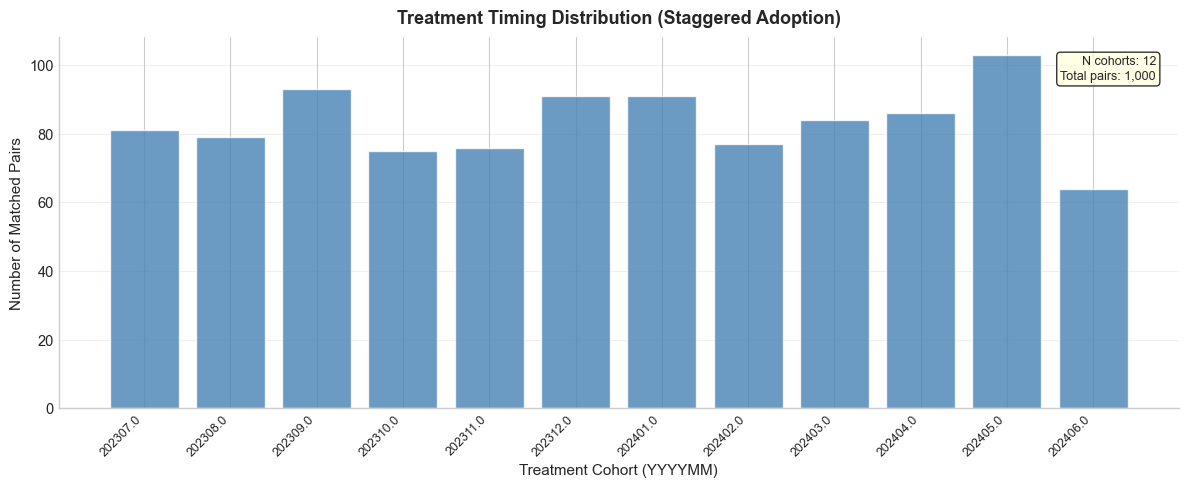

In [10]:
# Plot cohort distribution (staggered adoption pattern)
dashboard.plot_cohort_distribution()


---

## 7. Run Validation Checks

Before estimation, validate data quality and assumptions:


In [11]:
# Run validation checks
validation_results = analyzer.validate(verbose=True)


CAUSAL ANALYZER VALIDATION
  Treated units:     1000
  Control units:     1000
  Pre-treatment obs: 23028
  Post-treatment obs: 24972

  sufficient_sample         ✓ PASS
  balanced_time             ✓ PASS
  no_extreme_outliers       ✓ PASS
  pretrend_test             ✓ PASS

✓ All checks passed - Ready for analysis!


---

## 8. Estimate Staggered ATT

The `estimate()` method computes the Callaway & Sant'Anna style staggered ATT:


In [12]:
# Estimate staggered ATT
results = analyzer.estimate(
    pre_periods=6,      # Number of pre-treatment periods
    post_periods=12     # Number of post-treatment periods
)

# Display the result object
print(results)


STAGGERED DiD RESULT (Callaway-Sant'Anna Style)
  Overall ATT:  13,669.5709 ***
  ATT (%):      5.94% (vs baseline)
  SE:           140.4800
  95% CI:       [13,394.2300, 13,944.9118]
  p-value:      0.0000

  N treated:    1,000
  N control:    1,000
  N pairs:      1,000

  Pre-trend test: PASS (p=0.0751)


### Main Results (Formatted Output)


In [13]:
# Formatted main results (use dashboard method)
dashboard.print_main_results(true_effect=TRUE_EFFECT)


MAIN RESULTS: Overall Average Treatment Effect (ATT)
  Overall ATT:            13,670 ***
  Standard Error:         140.48
  95% CI:           [13,394, 13,945]
  p-value:                0.0000
  Effect (% base):         5.94%
-------------------------------------------------------
  N Matched Pairs:         1,000
  N Treated Units:         1,000
  N Control Units:         1,000
-------------------------------------------------------
  True Effect:            15,000
  Recovery Error:           8.9%


---

## 9. ATT(g,t) Table: Core Staggered DiD Output

The **ATT(g,t) table** shows treatment effects for each cohort (g) at each event time (t). This is the fundamental output that avoids TWFE bias.

**Key Property**: The overall ATT equals the weighted average of the post-treatment cells.


In [14]:
# Get the ATT(g,t) table from results
att_table = results.att_table

print("ATT(g,t) Table: Treatment Effects by Cohort × Event Time")
print("="*60)
display(att_table.head(20))

ATT(g,t) Table: Treatment Effects by Cohort × Event Time


,e=-6,e=-5,e=-4,e=-3,e=-2,e=-1,e=0,e=+1,e=+2,e=+3,e=+4,e=+5,e=+6,e=+7,e=+8,e=+9,e=+10,e=+11,e=+12
cohort,,,,,,,,,,,,,,,,,,,
202307.0,1916.938987,-706.013527,2053.516550,205.711990,-1588.371226,-1881.782774,6923.867538,11990.956166,14335.456529,12344.386167,15521.062529,17709.449303,15875.014428,18991.165458,18138.808473,16725.226240,15939.350237,15504.207056,18079.681081
202308.0,-1463.397442,-728.825843,743.870878,-1262.933116,1631.279772,-571.369404,4796.102328,9032.725625,15066.269469,11820.810033,10475.807683,14728.152601,10949.421990,13231.385640,15300.048490,14234.110434,13024.010503,14506.919619,14060.380156
202309.0,-1552.205690,-1542.668969,1982.685614,-827.350545,1145.425627,-1453.710850,4022.903463,8832.471138,13334.763737,15375.907505,15392.446267,14918.659185,14784.472933,15652.120452,14317.054690,12931.679570,16663.734574,16547.129264,14209.854678
202310.0,2774.989913,-855.731563,1822.492201,-980.063365,-1693.121945,-1248.253425,4961.811974,7942.089036,16526.217636,16282.718953,16081.666874,15024.669229,14820.332463,14208.514519,14365.794105,13304.382272,17625.542232,11498.453416,14235.093188
202311.0,1503.213742,-1673.890805,1669.373414,256.091347,-2027.772073,-1398.061248,5043.674162,7266.241919,17884.581530,13136.005564,13793.400640,15288.550263,13859.448749,14106.363804,17237.908377,16479.764740,16540.342581,16806.992709,16672.363447
202312.0,-245.575783,-2045.208418,-800.416072,94.736987,1626.239932,-1627.565230,5032.153062,12602.606294,13721.442310,16595.625683,17755.890186,13446.019491,12307.343602,13947.194033,14851.052844,16520.621890,14612.467231,16076.432023,13438.953158
202401.0,-459.460557,-683.863269,-2091.773653,-1040.789918,3150.352152,747.348368,6925.511118,9080.383169,14278.579221,14523.697594,16472.846314,16480.696746,13163.070206,15655.551943,14527.101277,15094.549008,15167.729075,13486.167028,NaN
202402.0,-2238.165146,1900.392290,-2905.922474,2485.030630,811.766419,3555.829233,6003.599902,10797.322290,13784.211158,13437.197892,14784.804414,13889.763743,14314.585978,14320.210603,18091.938811,14902.960729,15664.580397,NaN,NaN
202403.0,2816.079519,1962.891432,-937.763730,478.048543,1584.425407,547.597222,5857.837646,9630.921039,12895.007769,15633.445238,15782.383518,17294.438554,16255.127599,14005.089265,14700.222276,13918.425947,NaN,NaN,NaN


### Effect Matrix Heatmap

Visualize the ATT(g,t) table as a heatmap:


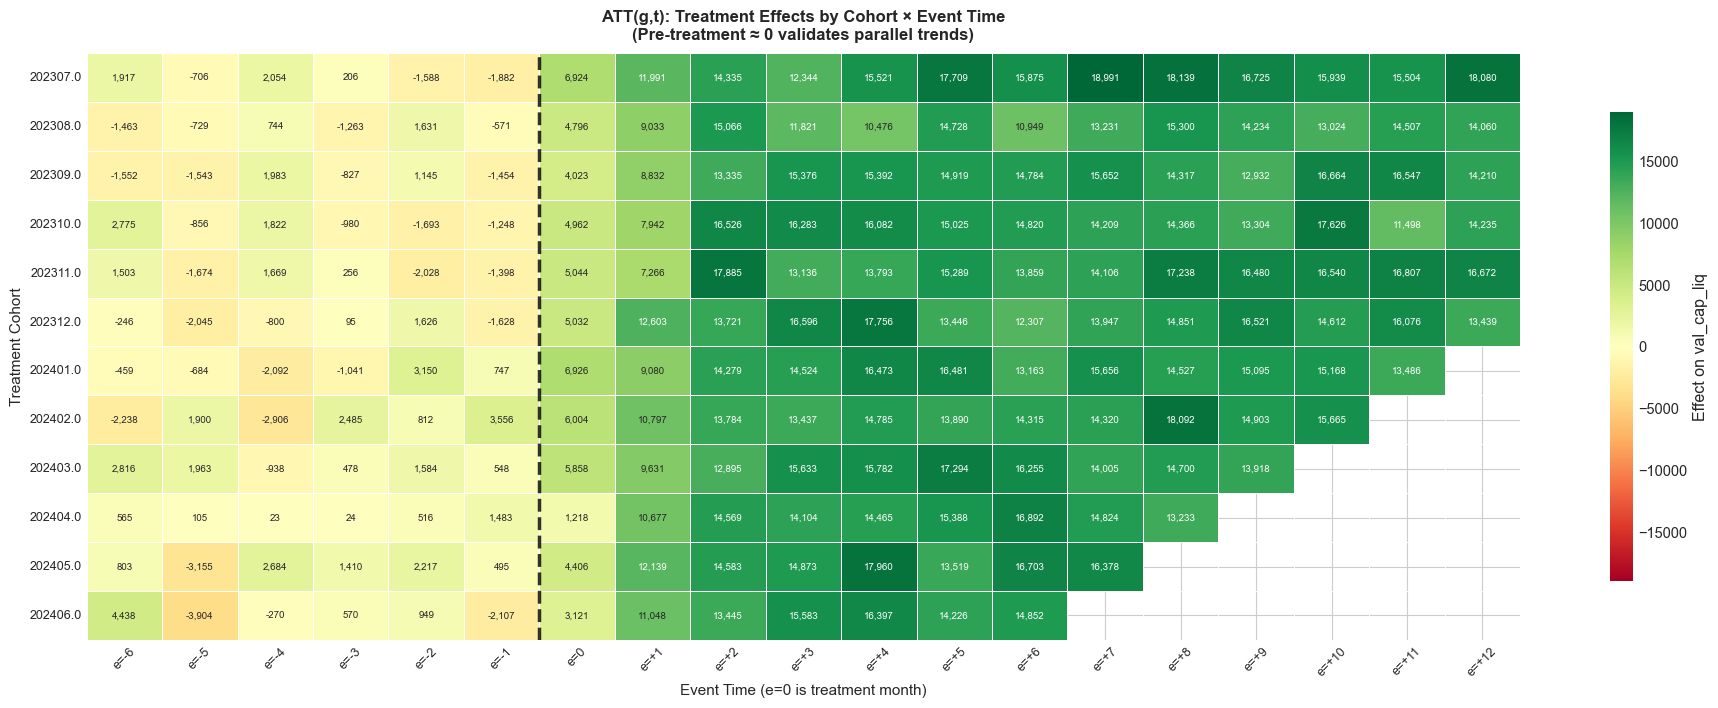

In [15]:
# ATT(g,t) heatmap
dashboard.plot_att_heatmap(pre_periods=6, post_periods=12)


### Reconciliation Check

Verify that the overall ATT equals the weighted average of ATT(g,t) cells:


In [16]:
# Reconciliation check
dashboard.print_reconciliation(pre_periods=6, post_periods=12)


RECONCILIATION CHECK
  Overall ATT (reported):        13,669.57
  Weighted avg of cells:         13,669.57
  Difference:                     0.000000
-------------------------------------------------------
  Result:  ✓ PASS (difference < 0.01)


---

## 10. Event Study: Dynamic Treatment Effects

The event study aggregates ATT(g,t) across cohorts to show how effects evolve over time.


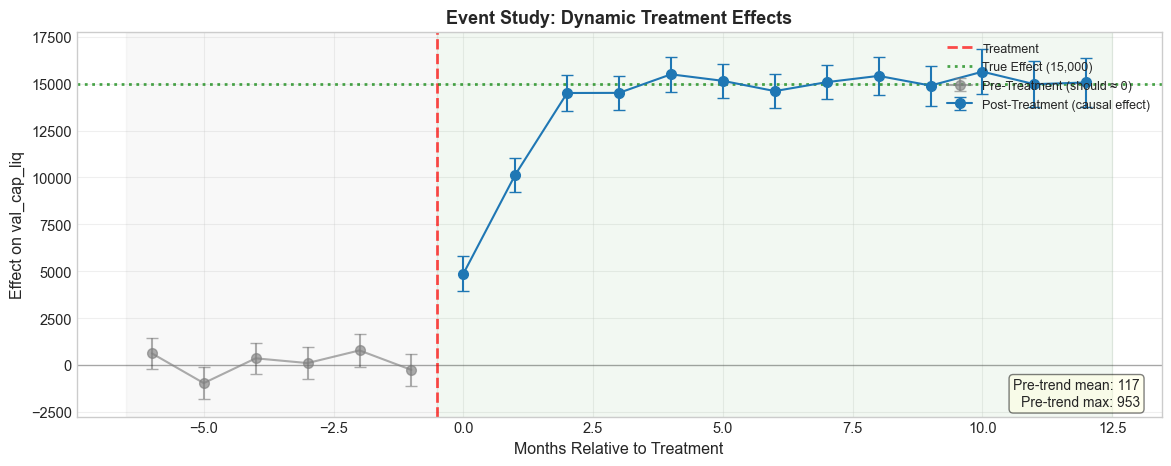

In [17]:
# Plot event study with true effect line for validation
dashboard.plot_event_study(pre_periods=6, post_periods=12, true_effect=TRUE_EFFECT)


---

## 11. Pre-Trend Diagnostics

Pre-treatment effects should be **statistically indistinguishable from zero**. The library provides a **joint Wald test** on all lead coefficients.


In [18]:
# Pre-trend test results
dashboard.print_pretrend_test()


PRE-TREND TEST (Parallel Trends Diagnostic)
  Test Type:        Joint Wald test on lead coefficients
  Wald Statistic:          11.46
  Degrees of Freedom:          6
  p-value:                0.0751
-------------------------------------------------------
  Result:           ✓ PASS (p > 0.05)
-------------------------------------------------------
  Interpretation:
    We CANNOT reject H₀ that pre-treatment effects = 0.
    This supports the parallel trends assumption.


---

## 12. Cohort Effects: Heterogeneity Across Treatment Groups


COHORT EFFECTS: Treatment Effect Heterogeneity
  Number of Cohorts:             12
  Mean ATT:                  13,601
  Std ATT:                      743
  Min ATT:                   12,402
  Max ATT:                   15,237
  Significant (p<0.05):          12 / 12
-------------------------------------------------------
  True Effect:               15,000


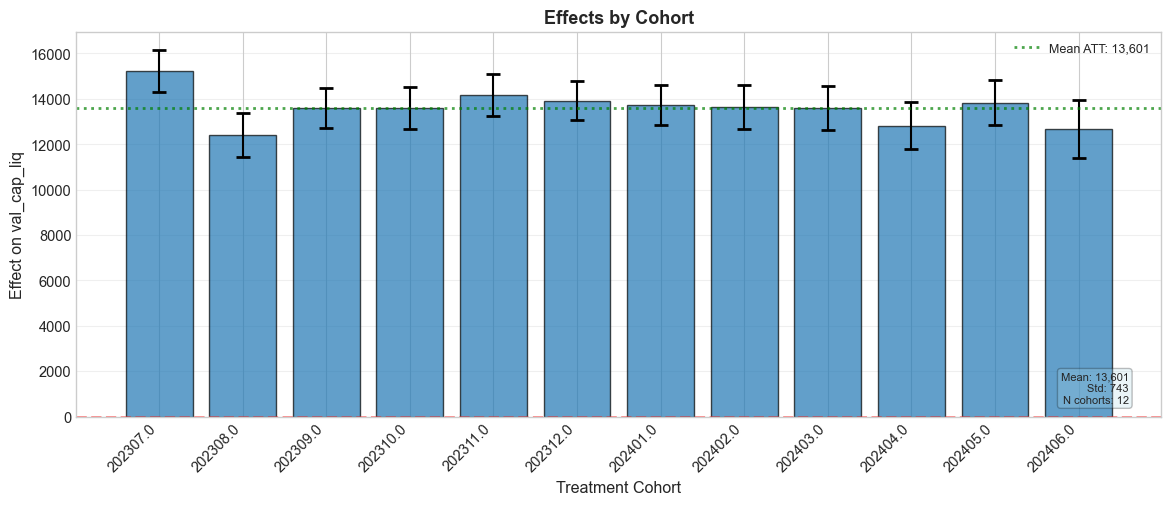

In [19]:
# Plot cohort effects
dashboard.plot_cohort_effects()

# Cohort summary statistics
dashboard.print_cohort_summary(true_effect=TRUE_EFFECT)


---

## 13. Robustness Check: Stacked DiD Comparison

The **Stacked DiD** estimator provides a robustness check. Similar estimates increase confidence in results.


In [20]:
# Robustness check (runs stacked DiD)
dashboard.print_robustness(pre_periods=6, post_periods=12, true_effect=TRUE_EFFECT)


ROBUSTNESS CHECK: Primary vs Stacked DiD
  Primary ATT:              13,670
  Stacked DiD ATT:          13,657
  Difference:                  0.1%
-------------------------------------------------------
  True Effect:              15,000
-------------------------------------------------------
  Result: ✓ PASS - Estimates are consistent (<20% difference)


---

## 14. Additional Diagnostics

### Balance Check (Love Plot)
Shows Standardized Mean Differences (SMD) between treated and control. Good balance means |SMD| < 0.1.


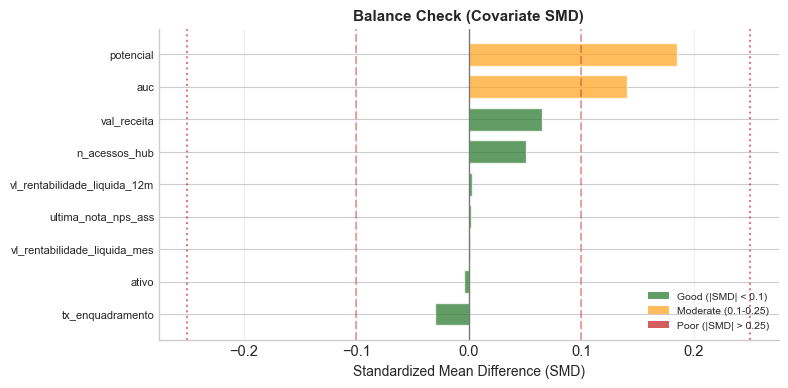

In [21]:
# Balance check (love plot) with improved readability for many features
dashboard.plot_love_plot(max_features=15)


### Parallel Trends Visualization
Visual inspection of pre-treatment trends for treated vs control groups:


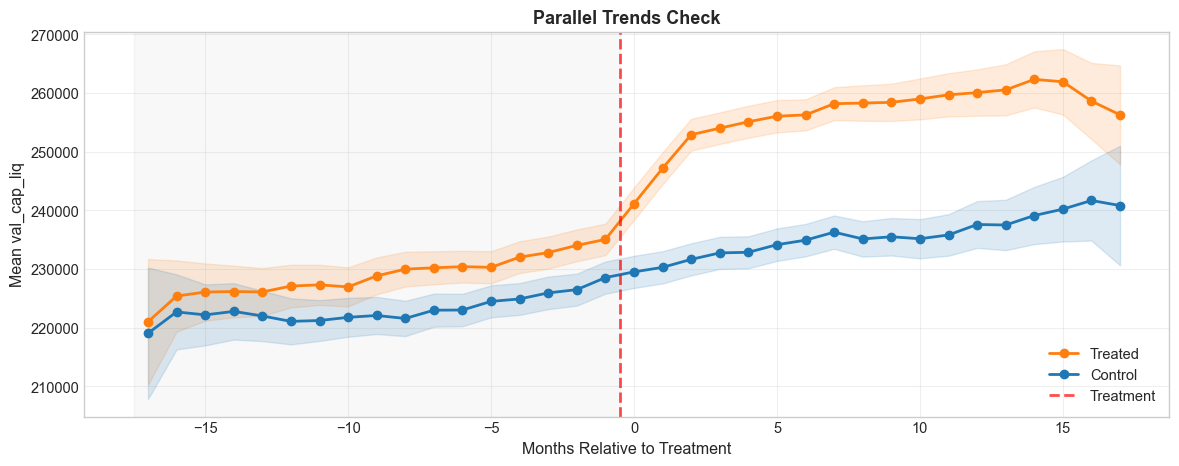

In [22]:
# Parallel trends visualization
dashboard.plot_parallel_trends()


---

## 15. Generate Full Report

For executive presentations, generate a comprehensive visual report with all diagnostics:


✓ Executive report saved to: staggered_analysis_report.png


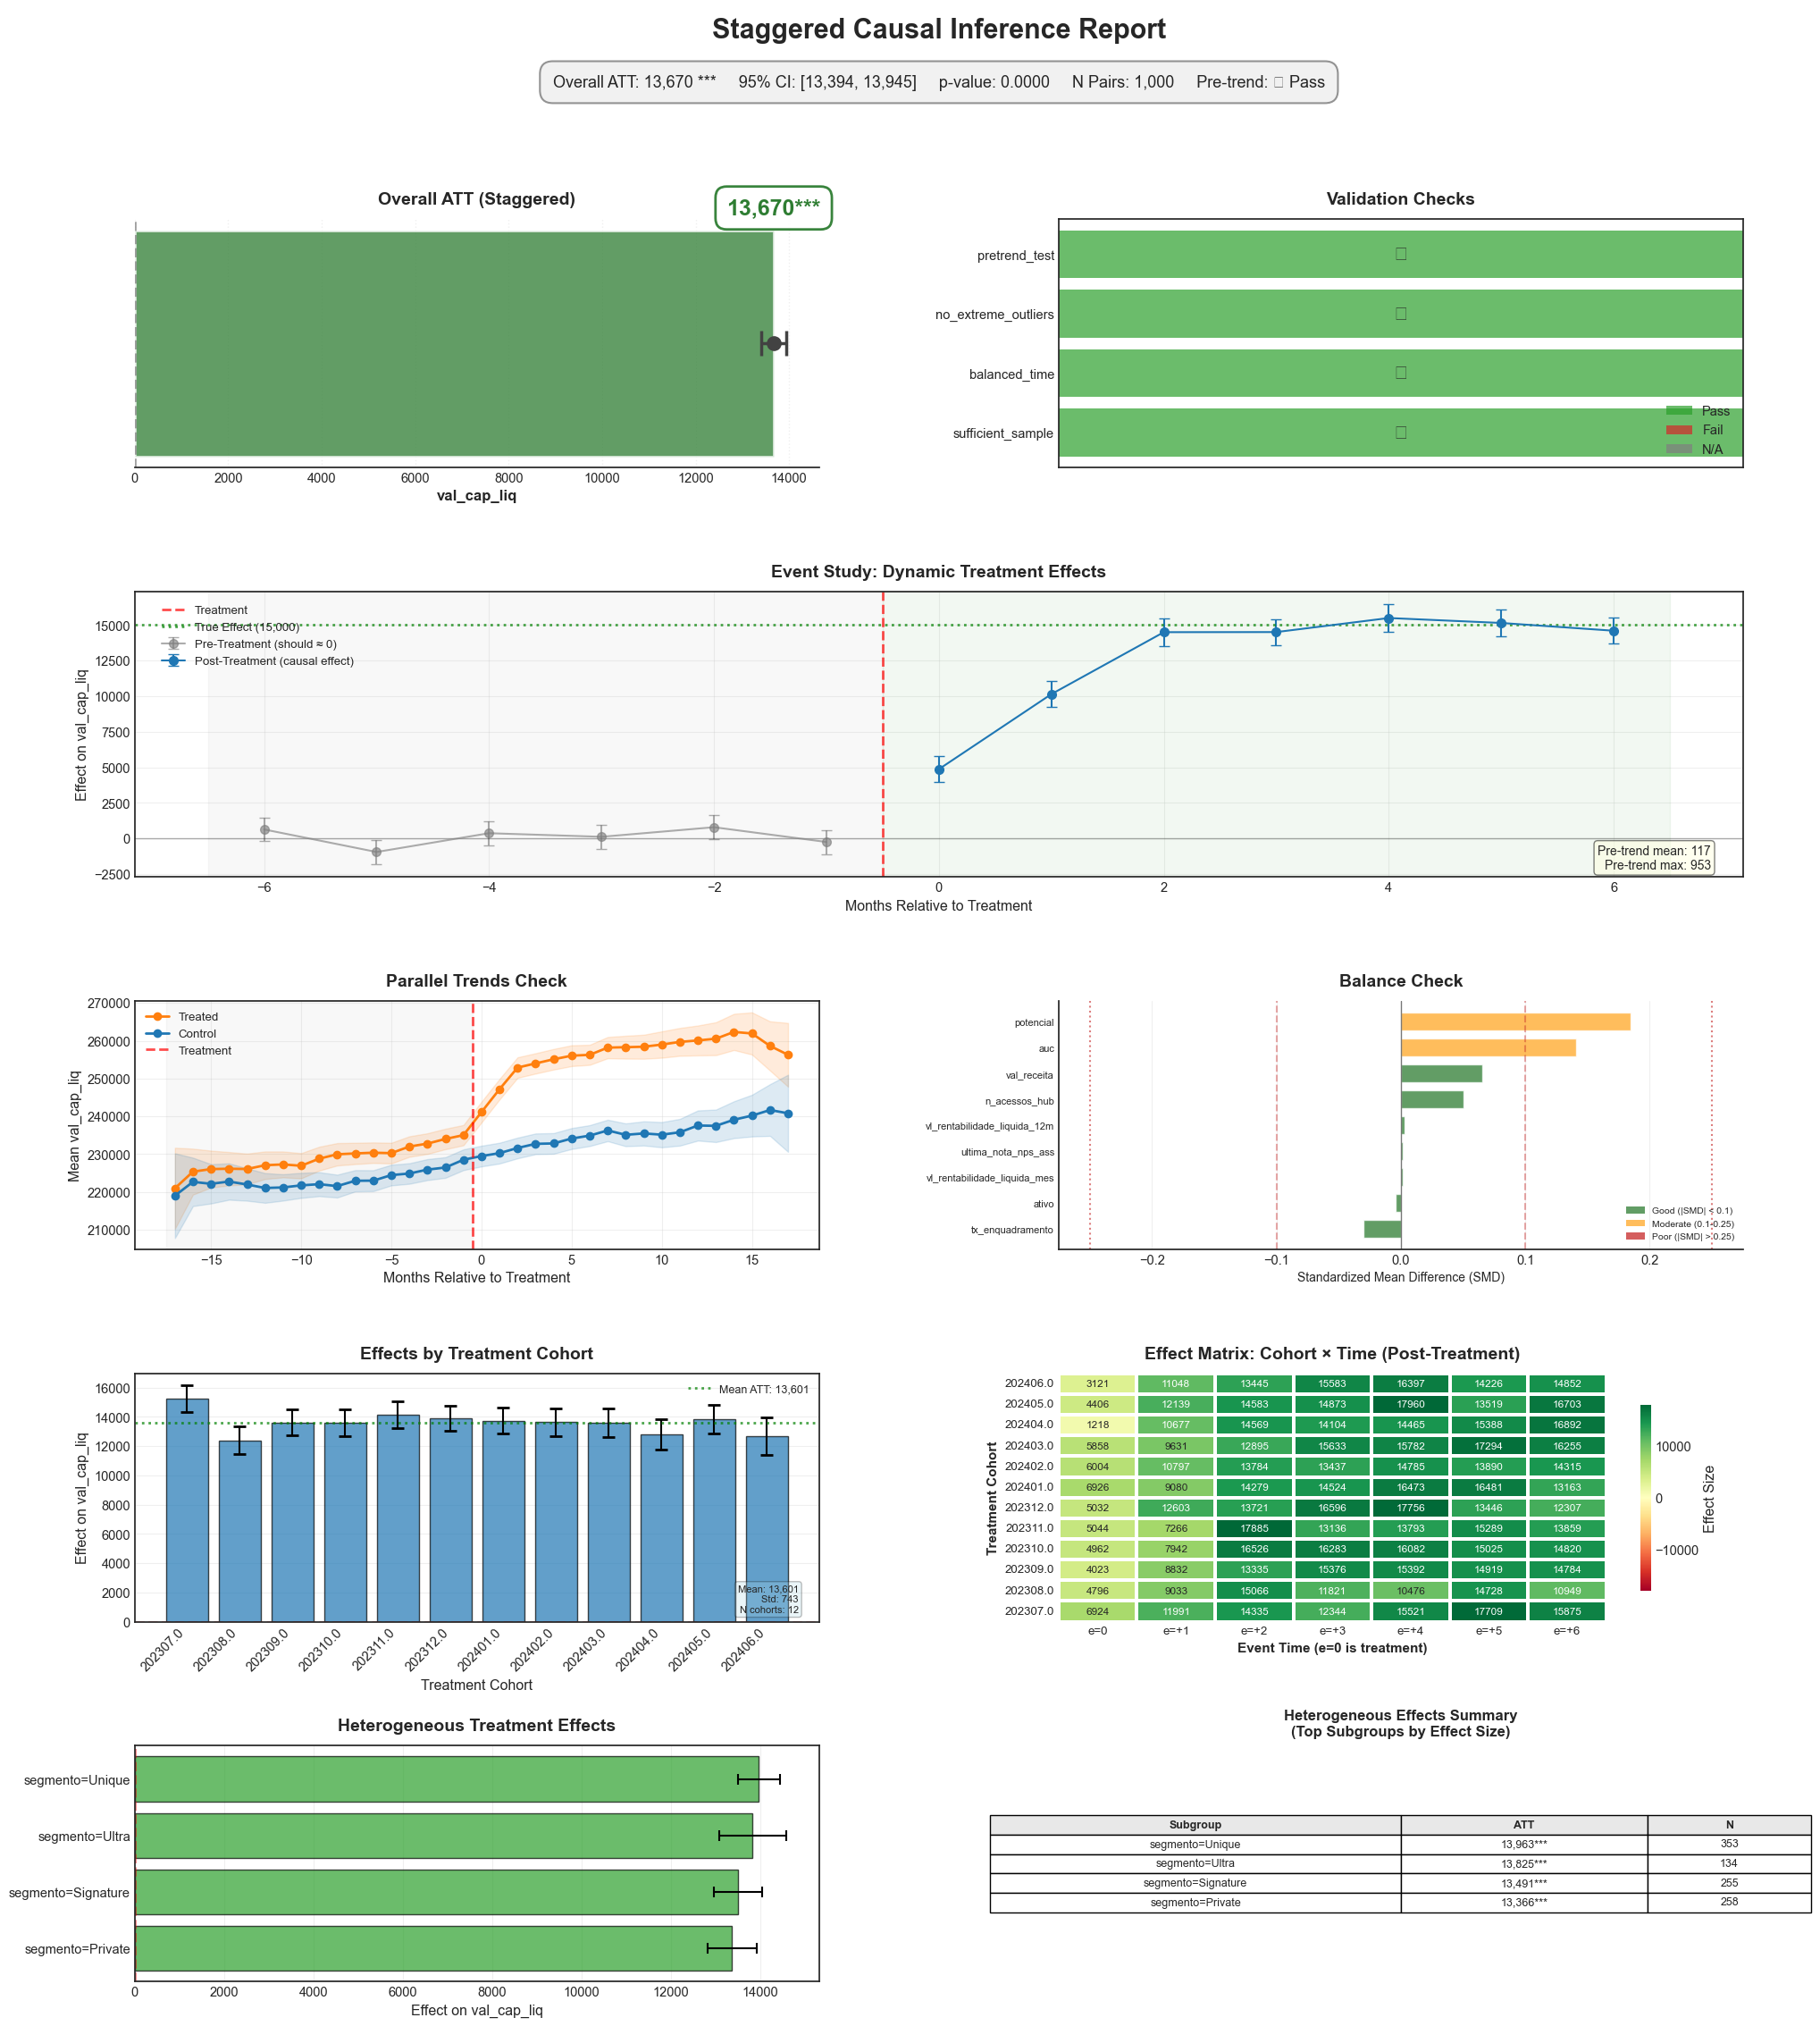

In [23]:
# Generate full executive report
dashboard.full_report(
    heterogeneity_features=['segmento'],
    true_effect=TRUE_EFFECT,
    save_path='staggered_analysis_report.png'
)


In [26]:
dashboard.print_event_study_table()

EVENT STUDY: Aggregated Effects by Relative Time
    Time          ATT         SE                   95% CI    p-value   Sig
----------------------------------------------------------------------
     M+0        4,870        475           [3,940, 5,801]     0.0000   ***
     M+1       10,143        467          [9,228, 11,058]     0.0000   ***
     M+2       14,498        485         [13,548, 15,449]     0.0000   ***
     M+3       14,505        463         [13,599, 15,412]     0.0000   ***
     M+4       15,493        484         [14,545, 16,441]     0.0000   ***
     M+5       15,146        468         [14,229, 16,063]     0.0000   ***
     M+6       14,600        460         [13,699, 15,501]     0.0000   ***
     M+7       15,076        467         [14,161, 15,992]     0.0000   ***
     M+8       15,410        511         [14,408, 16,411]     0.0000   ***
     M+9       14,894        544         [13,827, 15,961]     0.0000   ***
    M+10       15,633        614         [14,429, 16,83

---

## 16. Summary Table


In [24]:
# Get summary table from dashboard
summary = dashboard.summary_table()
display(summary)


,Metric,Value
0,Overall ATT,"13,670"
1,95% CI Lower,"13,394"
2,95% CI Upper,"13,945"
3,p-value,0.0000
4,Effect as % of Baseline,5.94%
5,N Treated,"1,000"
6,N Control,"1,000"
7,N Pairs,"1,000"
8,N Cohorts,12
9,Pre-trend Test,PASS


---

## Summary: Key Takeaways

### Component-Level Workflow

```python
# 1. Propensity Score Estimation
from src.propensity_model import CausalPropensityScore
ps_model = CausalPropensityScore(id_col='cod_conta')
scores = ps_model.fit_predict_honest(X, y)

# 2. Matching
from src.matching import PropensityMatcher
matcher = PropensityMatcher(use_caliper=True)
matched_df = matcher.match(df, 'treatment', 'id', 'propensity_score', 'cohort')

# 3. Analysis
from src.causal_analyzer import CausalAnalyzer
analyzer = CausalAnalyzer(matched_df, panel_df, 'outcome', 'time', 'id')
results = analyzer.estimate()

# 4. Visualization
from src.causal_dashboard import CausalDashboard
dashboard = CausalDashboard(analyzer)
dashboard.full_report()
```

### What Each Component Provides

| Component | Purpose |
|-----------|---------|
| `CausalPropensityScore` | LightGBM-based propensity scores with honest estimation |
| `PropensityMatcher` | Caliper-based 1:1 matching within cohorts |
| `CausalAnalyzer` | Staggered ATT(g,t) estimation, event studies, pre-trend tests |
| `CausalDashboard` | Visualizations, formatted outputs, full reports |

### References

- **Callaway & Sant'Anna (2021)**: Difference-in-differences with multiple time periods
- **Sun & Abraham (2021)**: Estimating dynamic treatment effects in event studies
- **Roth et al.**: Pre-testing for parallel trends in difference-in-differences
